### History Matching LAI
#### Observational Target: CLM-SP

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
import gpflow
import tensorflow as tf
from typing import Tuple, Optional
import random
from sklearn.preprocessing import MinMaxScaler 
from esem.utils import get_random_params

import warnings
warnings.filterwarnings("ignore")

2023-12-29 15:32:59.447517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-29 15:32:59.645524: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-29 15:32:59.664865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/casper/23.10/spack/opt/spack/openmpi/4.1.6/oneapi/2023.2.1/dgcv/lib:/glade/u/apps/

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") ; sys.path.append("../../") 
from ppe_analysis.analysis import *
from pyfunctions import *

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='3:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(50)

# Setup your client
client = Client(cluster)

In [71]:
client

<Client: 'tcp://128.117.208.69:39517' processes=50 threads=50, memory=0.91 TiB>

### Load sample and emulated predictions

In [6]:
# load original parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
lhc_params = df.drop(columns='member')
num_params = len(lhc_params.columns)

In [7]:
u_params     = ['FUN_fracfixers','KCN','a_fix','crit_dayl','d_max','fff','fstor2tran','grperc',
                'jmaxb0','jmaxb1','kcha','lmrha','lmrhd','nstem','q10_mr','soilpsi_off','sucsat_sf',
                'tpu25ratio','tpuse_sf','wc2wjb0']
pft_params   = ['froot_leaf','kmax','krmax','leaf_long','leafcn','lmr_intercept_atkin',
                'medlynslope','medlynintercept','psi50','slatop','stem_leaf','theta_cj']
col_names = ['FUN_fracfixers','KCN','a_fix','crit_dayl','d_max','fff','fstor2tran','grperc',
                'jmaxb0','jmaxb1','kcha','lmrha','lmrhd','nstem','q10_mr','soilpsi_off','sucsat_sf',
                'tpu25ratio','tpuse_sf','wc2wjb0','froot_leaf','kmax','krmax','leaf_long','leafcn','lmr_intercept_atkin',
                'medlynslope','medlynintercept','psi50','slatop','stem_leaf','theta_cj']

In [8]:
#load sample
u_sample= np.loadtxt('/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/PxB_universal_sample_12-28.txt',delimiter=',')
n_usamp = len(u_sample)

pft_sample= np.loadtxt('/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/PxB_pft_sample_12-28.txt',delimiter=',')
n_psamp = len(pft_sample)

In [9]:
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pft_names=[str(p)[2:-1].strip() for p in pfts.values]

# Linnia hand selected this subset of biomes - need to build a more robust selection process
pb_index = {}
pb_index[pft_names[1]] = [2,5,6,7,8]
pb_index[pft_names[2]] = [4,5,6,8,9]
pb_index[pft_names[3]] = [8,9]
pb_index[pft_names[4]] = [1,2,3]
pb_index[pft_names[5]] = [2,3]# drop [5,6]
pb_index[pft_names[6]] = [2,3]
pb_index[pft_names[7]] = [5,6,7]
pb_index[pft_names[8]] = [5,6,8,9]
pb_index[pft_names[9]] = []
pb_index[pft_names[10]] = [6,7]
pb_index[pft_names[11]] = [8,9]
pb_index[pft_names[12]] = [7,8,9] # drop 5,6 
pb_index[pft_names[13]] = [2,3,5,6,7,8]
pb_index[pft_names[14]] = [1,2,3] # drop 5,6,7
pb_index[pft_names[15]] = [1,2,3,5,6,7,8]

### Load Observational Target : CLM-SP

In [90]:
#read in biome vector and pft vector
whit=xr.open_dataset('whit/whitkey.nc')
f='/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0000.clm2.h1.2005-02-01-00000.nc'
ds=xr.open_dataset(f)
pfts=ds.pfts1d_itype_veg

#define the pft-x-biome group
pftbiome=xr.DataArray(np.zeros(ds.pft.shape)+np.nan,dims='pft',name='pb')
for i in range(1,17):
    pftbiome[pfts==i]=whit.biome+10*i

lapft=xr.open_dataset('landarea_transient.nc').landarea_pft
a=lapft.groupby('time.year').mean()
asum=a.groupby(pftbiome).sum()
minarea=5e4
asum=asum.where(asum>minarea)


In [91]:
# CLM-SP LAI, by pft
dsp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc')
dsp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')

#if (annmax==True):
lai_sp=amax(dsp.TLAI).sel(year=2000)
#else: # annual mean
#    lai_sp=amean(dsp.TLAI).sel(year=2000)
laig=pftgrid(lai_sp,dsp)

jvals, ivals = get_sparsegrid() # function in pyfunctions.py
dsp_sg = laig[:,jvals,ivals]


In [92]:
dsp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc')
dsp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
sp_lai_amax=amax(dsp.TLAI).sel(year=2000)
sp_lai_amean=amean(dsp.TLAI).sel(year=2000)


def get_sp_pb(pft,biome):

    if (pft<12):
        lai_sp=sp_lai_amax
    else: # annual mean
        lai_sp=sp_lai_amean
    laig=pftgrid(lai_sp,dsp)

    jvals, ivals = get_sparsegrid() # function in pyfunctions.py
    dsp_sg = laig[:,jvals,ivals]

    b = whit.biome
    ix = np.where(b==biome)[0]

    ai = a.mean(dim='year').sel(pft=pft)
    pb = pft*10+biome-10
    asumi = asum.mean(dim='year')[pb]

    da = dsp_sg.isel(pft=pft,gridcell=ix)

    sp_lai_pb = (1/asumi)*(ai.isel(pft=ix).values*da).sum().compute()
    #print(biome_names[biome],sp_lai_pb.values,da_pb.isel(ens=0).values[0])
    
    return sp_lai_pb.values


### Estimate observational variance

In [13]:
# CLM-SP LAI on sparse grid
la = get_la()
SP_sg = get_SP('h0')

BM_sp = bmean(amax(SP_sg).mean(dim='year'),la).compute()
BMmn_sp = bmean(amean(SP_sg).mean(dim='year'),la).compute()

In [14]:
# load regridded ILAMB datasets (MODIS, AVHRR, AVH15C1)
ds_ilamb =xr.open_dataset('/glade/work/linnia/ILAMB/ilamb_data/regridded/ILAMB_LAI_regridded.nc')
Amax_LAI_MODIS = amax(ds_ilamb.MODIS_LAI).mean(dim='year')

jvals, ivals = get_sparsegrid()

BM_MODIS = bmean(amax(ds_ilamb.MODIS_LAI[:,jvals,ivals]).mean(dim='year'),la).compute()
mask = xr.where(BM_MODIS!=0,1,0)
BM_AVHRR = bmean(amax(ds_ilamb.AVHRR_LAI[:,jvals,ivals]).mean(dim='year'),la).compute()
BM_AVH15C1 = bmean(amax(ds_ilamb.AVH15C1_LAI[:,jvals,ivals]).mean(dim='year'),la).compute()

BM_LAI_obs = [BM_MODIS, BM_AVHRR, BM_AVH15C1, BM_sp]

In [15]:
# variance across datasets ( Biome mean lai max )
obs_var_laimax = np.var(BM_LAI_obs,axis=0)
obs_var_laimax

array([0.00136562, 0.51870252, 0.01652762, 0.00319137, 0.05233441,
       0.07114466, 0.05400439, 0.0015113 , 0.04013954, 0.0320973 ])

In [16]:
# load regridded ILAMB datasets (MODIS, AVHRR, AVH15C1)
ds_ilamb =xr.open_dataset('/glade/work/linnia/ILAMB/ilamb_data/regridded/ILAMB_LAI_regridded.nc')
jvals, ivals = get_sparsegrid()

BMmn_MODIS = bmean(amean(ds_ilamb.MODIS_LAI[:,jvals,ivals]).mean(dim='year'),la).compute()
mask = xr.where(BMmn_MODIS!=0,1,0)
BMmn_AVHRR = bmean(amean(ds_ilamb.AVHRR_LAI[:,jvals,ivals]).mean(dim='year'),la).compute()
BMmn_AVH15C1 = bmean(amean(ds_ilamb.AVH15C1_LAI[:,jvals,ivals]).mean(dim='year'),la).compute()

BMmn_LAI_obs = [BMmn_MODIS, BMmn_AVHRR, BMmn_AVH15C1, BMmn_sp]

In [17]:
# variance across datasets ( Biome mean lai annual mean )
obs_var_laimn = np.var(BMmn_LAI_obs,axis=0)
obs_var_laimn

array([1.26520777e-05, 4.88205026e-01, 5.35127185e-03, 4.10337409e-04,
       2.85014217e-02, 2.36333087e-02, 3.96866942e-03, 2.54007424e-04,
       9.34136176e-02, 1.05203772e-02])

### Calculate Implausibility for Universal sets

In [18]:
uset_plausibility = np.empty((n_usamp,16))*np.NaN

for p in range(1,16):
    print(p)
    I_tmp = np.empty((5000,500,10))*np.NaN
    
    for b in pb_index[pft_names[p]]:
        o = get_sp_pb(p,b)
        if (p<12):
            ovar = obs_var_laimax[b]
        else:
            ovar = obs_var_laimn[b]

        # load the emulator predicted value for PFTxBiome (new sample)
        file1 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_pft'+str(p)+'_biome'+str(b)+'.npy'
        y_pred = np.load(file1)
        file2 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_pft'+str(p)+'_biome'+str(b)+'_var.npy'
        y_pred_var = np.load(file2)
        
        I = np.abs(o-y_pred) / np.sqrt(ovar + y_pred_var) # implausibility 
        I_tmp[:,:,b] = I.reshape((n_usamp,n_psamp))
        
    ix = I_tmp.copy()
    ix[ix<3] = 1
    ix[ix>=3] = 0
    x = np.nanmean(ix,axis=2)
    uset_plausibility[:,p] = np.any(x==1,axis=1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [19]:
uset_plausibility[:,9] = np.NaN # ignore this PFT

In [20]:
# identify universal sets that have PFT sets in NROY for all PFTs
ix_usets_lai = np.where(np.nanmean(uset_plausibility,axis=1)==1)

In [21]:
np.shape(ix_usets_lai)

(1, 3119)

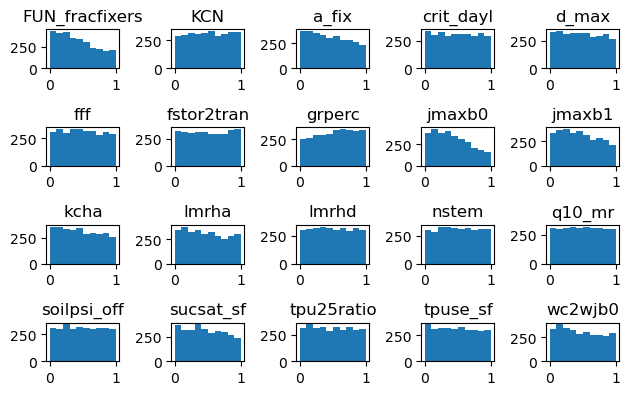

In [22]:
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.hist(u_sample[ix_usets_lai[0],i])
    plt.title(u_params[i])
plt.tight_layout()

### V2: Inflate the PFT sample after selecting Universal sets

In [23]:
### Select Universal sets
nsets = 500
selected_sets_ids = np.random.choice(ix_usets_lai[0],nsets,replace=False)

In [24]:
selected_sets_ids

array([4554, 3230,  441,   24, 4077, 1051,  330, 3033, 3371, 2118, 4922,
       2132, 2173, 2236, 3914, 3356, 3473, 2081,  509,  795, 2818, 3895,
       1329, 2428, 2227, 2347, 3027,  380, 2876, 1256, 1607, 2619, 4526,
       1876, 2066, 4760, 1522, 3727,  294,  363, 2283,  555, 2689,  864,
       1127,   11, 2970, 2356, 3865, 2135, 1571, 4298, 4596,  620, 3309,
       1951, 3421, 2873, 2780, 4748, 1541, 3816, 3346, 4865, 2784, 4474,
       2402, 4627, 3002, 4393, 3281,    2, 3474, 2411,  668, 4854, 2599,
       4966, 4855,  302, 2629, 3533, 1124, 4931,  218, 4062, 2569, 4977,
       1359, 2891, 2939, 4994, 2414,  185, 4890, 1784,  160, 2728,  860,
       3764, 1140, 3399,  840, 1339, 2207, 3518,  534, 4845,  728, 2805,
        599, 3056, 1221,  941,  519, 3780, 2030, 1403, 3219, 4071,  963,
       2429,  180, 2883, 3607, 3526, 3995,  431, 3028, 3063, 4505, 2389,
       3092, 4170,  448, 4013, 3364,  201, 3805, 4904, 1253,  754, 1418,
       2456, 1378, 3083, 1863, 4525, 3240,  290, 23

In [60]:
# randomly sample PFT parameters
np.random.seed(842)
n_psamp2 = 10000
pft_sample2 = get_random_params(len(pft_params), n_psamp2)
np.savetxt("/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/PxB_pft_sample_12-28_large.txt", pft_sample2,delimiter=',')

In [61]:
# concatenate sample
for i,u in enumerate(selected_sets_ids):
    if (i==0):
        sample = np.concatenate((np.tile(u_sample[u,:],(n_psamp2,1)),pft_sample2),axis=1)
    else:
        s = np.concatenate((np.tile(u_sample[u,:],(n_psamp2,1)),pft_sample2),axis=1)
        sample = np.concatenate((sample,s),axis=0)
        
df_s = pd.DataFrame(sample,columns=col_names)
df_sample = df_s[lhc_params.columns]

In [72]:
%%time
# Fastest (4 min per 10K per PFT per Biome)
nsets = 500
pset_plausibility = np.empty((nsets,16,10,n_psamp2))*np.NaN

for p in range(1,16):
    print(p)
    for i,b in enumerate(pb_index[pft_names[p]]):  
        o = get_sp_pb(p,b)
        if (p<12):
            ovar = obs_var_laimax[b]
        else:
            ovar = obs_var_laimn[b]

        loaded_emulator = tf.saved_model.load('./models/pft'+str(p)+'_biome'+str(b))
        
        st = 0
        for i,u in enumerate(selected_sets_ids):
            en = st+n_psamp2
            y, y_var = loaded_emulator.predict(df_sample.iloc[st:en].values)

            I = np.abs(o-y) / np.sqrt(ovar + y_var)
            pset_plausibility[i,p,b,:] = I[:,0]
            
            st = st+n_psamp2

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
CPU times: user 3h 2min 47s, sys: 3min 19s, total: 3h 6min 7s
Wall time: 3h 14min 55s


### Calculate implausibility for PFT sets

In [233]:
# OLD
pset_plausibility = np.empty((n_usamp,16,10,n_psamp))*np.NaN
for p in range(1,16):
    print(p)
    for b in pb_index[pft_names[p]]:
        o = get_sp_pb(p,b)
        if (p<12):
            ovar = obs_var_laimax[b]
        else:
            ovar = obs_var_laimn[b]

        file1 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_pft'+str(p)+'_biome'+str(b)+'_large.npy'
        y_pred_lai = np.load(file1)
        lai_pred = np.reshape(y_pred_lai,(n_usamp,n_psamp))
        
        file2 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_pft'+str(p)+'_biome'+str(b)+'_var_large.npy'
        y_pred_var = np.load(file2)
        lai_pred_var = np.reshape(y_pred_var,(n_usamp,n_psamp))

        for i,u in enumerate(ix_usets_lai[0]):
            y = lai_pred[u,:]
            y_var = lai_pred_var[u,:]

            I = np.abs(o-y) / np.sqrt(ovar + y_var)
            pset_plausibility[u,p,b,:] = I


4
5
6
7
8
9
10
11
12
13
14
15


### Sample one PFT set for each Universal set

In [74]:
tmp = pset_plausibility.copy()
tmp[tmp<3]=1
tmp[tmp>=3]=0
pftset_index = {}
ix_pset = np.empty((nsets,16))*np.NaN
for i,u in enumerate(selected_sets_ids):
    for p in [1,2,3,4,5,6,7,8,10,11,12,13,14,15]:
        ix = tmp[i,p,:,:]
        ix_in = np.where(np.nanmean(ix,axis=0)==1)[0]
        pftset_index[(u,p)] = ix_in
        ix_pset[i,p] = np.random.choice(ix_in,size=1,replace=False)


### Select sets

In [78]:
selected_usets = pd.DataFrame(u_sample[selected_sets_ids,:],columns=u_params)

In [79]:
selected_psamp_ids = ix_pset

In [80]:
selected_psets = np.ones([nsets,79,12])*0.5
for p in [1,2,3,4,5,6,7,8,10,11,12,13,14,15]:
    ix = selected_psamp_ids[:,p].astype(int)
    selected_psets[:,p,:] = pft_sample2[ix,:]

In [133]:
np.shape(np.unique(selected_psets[:,15,1]))

(399,)

### write selected sets

In [81]:
keys = lhc_params.columns
pset_dict = {}

In [82]:
for i,u in enumerate(u_params):
    pset_dict[u] = selected_usets[u].values
for i,p in enumerate(pft_params):
    pset_dict[p] = selected_psets[:,:,i]

In [83]:
extra_pfts = [0,9,16,17]
for i in range(250):
    pset_dict['medlynintercept'][i][extra_pfts]= 0.08
    pset_dict['theta_cj'][i][extra_pfts]=0.9

In [84]:
pset_dict[pset_dict==np.nan] = 0.5

In [85]:
np.save('PXB_psets_12-28.npy', pset_dict)

### Plot to check

In [86]:
new_sample = np.load('PXB_psets_12-28.npy',allow_pickle=True).item()

In [87]:
new_sample_r = np.empty((500,32,16))*np.NaN

for pft in range(1,16):
    for u in range(500):
        a=[] ; b=[]
        for i,up in enumerate(u_params):
            a.append(new_sample[up][u])
        for i,pp in enumerate(pft_params):
            b.append(new_sample[pp][u][pft])
        new_sample_r[u,:,pft] = np.hstack([a,b])

In [88]:
check_pred = np.empty((16,10,500))*np.NaN
for p in range(1,16):
    dfs = pd.DataFrame(new_sample_r[:,:,p],columns=col_names)
    df_sample = dfs[lhc_params.columns]
    
    for i,b in enumerate(pb_index[pft_names[p]]):
        
        loaded_emulator = tf.saved_model.load('./models/pft'+str(p)+'_biome'+str(b))
        y_pred, y_pred_var = loaded_emulator.predict(df_sample.values)
        
        check_pred[p,b,:] = y_pred.numpy().flatten()


In [93]:
biome_names = whit.biome_name.values
xp=1
xb=5
file1 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_pft'+str(xp)+'_biome'+str(xb)+'.npy'
y_predx = np.load(file1)
x = np.reshape(y_predx,(n_usamp,n_psamp))
xo = get_sp_pb(xp,xb)
xovar = obs_var_laimax[xb]

yp=4
yb=1
file1 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_pft'+str(yp)+'_biome'+str(yb)+'.npy'
y_predy = np.load(file1)
y = np.reshape(y_predy,(n_usamp,n_psamp))
yo = get_sp_pb(yp,yb)
yovar = obs_var_laimax[yb]


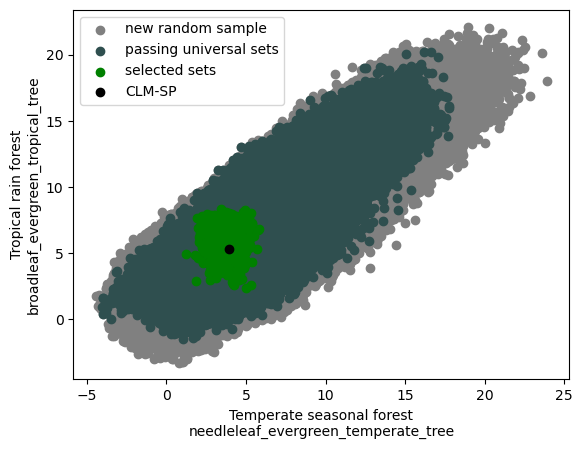

In [94]:
plt.scatter(y_predx,y_predy,c='grey',label='new random sample')
plt.scatter(x[selected_sets_ids,:],y[selected_sets_ids,:],c='darkslategrey',label = 'passing universal sets')
plt.scatter(check_pred[xp,xb,:],check_pred[yp,yb,:],c='green',label='selected sets')
plt.scatter(xo,yo,c='k',label='CLM-SP')
#plt.plot([xo-3*xovar**0.5,xo+3*xovar**0.5],[yo,yo],c='k')
#plt.plot([xo,xo],[yo-3*yovar**0.5,yo+3*yovar**0.5],c='k',label='obs+-3sd')
plt.xlabel(biome_names[xb]+'\n' + pft_names[xp]) 
plt.ylabel(biome_names[yb]+'\n' + pft_names[yp]) 
plt.legend()

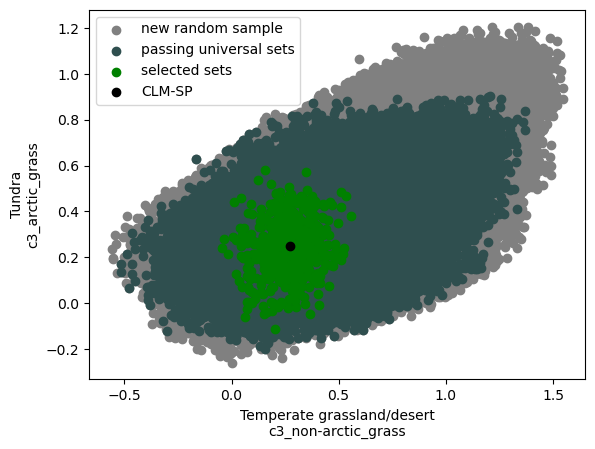

In [95]:
xp=13
xb=7
file1 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_pft'+str(xp)+'_biome'+str(xb)+'.npy'
y_predx = np.load(file1)
x = np.reshape(y_predx,(n_usamp,n_psamp))
xo = get_sp_pb(xp,xb)
xovar = obs_var_laimax[xb]

yp=12
yb=9
file1 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_pft'+str(yp)+'_biome'+str(yb)+'.npy'
y_predy = np.load(file1)
y = np.reshape(y_predy,(n_usamp,n_psamp))
yo = get_sp_pb(yp,yb)
yovar = obs_var_laimax[yb]

plt.scatter(y_predx,y_predy,c='grey',label='new random sample')
plt.scatter(x[selected_sets_ids,:],y[selected_sets_ids,:],c='darkslategrey',label = 'passing universal sets')
plt.scatter(check_pred[xp,xb,:],check_pred[yp,yb,:],c='green',label='selected sets')
plt.scatter(xo,yo,c='k',label='CLM-SP')
#plt.plot([xo-3*xovar**0.5,xo+3*xovar**0.5],[yo,yo],c='k')
#plt.plot([xo,xo],[yo-3*yovar**0.5,yo+3*yovar**0.5],c='k',label='obs+-3sd')
plt.xlabel(biome_names[xb]+'\n' + pft_names[xp]) 
plt.ylabel(biome_names[yb]+'\n' + pft_names[yp]) 
plt.legend()

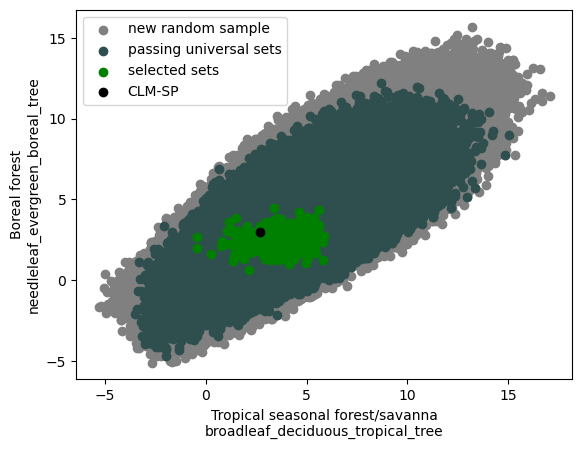

In [96]:
xp=6
xb=2
file1 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_pft'+str(xp)+'_biome'+str(xb)+'.npy'
y_predx = np.load(file1)
x = np.reshape(y_predx,(n_usamp,n_psamp))
xo = get_sp_pb(xp,xb)
xovar = obs_var_laimax[xb]

yp=2
yb=8
file1 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_pft'+str(yp)+'_biome'+str(yb)+'.npy'
y_predy = np.load(file1)
y = np.reshape(y_predy,(n_usamp,n_psamp))
yo = get_sp_pb(yp,yb)
yovar = obs_var_laimax[yb]

plt.scatter(y_predx,y_predy,c='grey',label='new random sample')
plt.scatter(x[selected_sets_ids,:],y[selected_sets_ids,:],c='darkslategrey',label = 'passing universal sets')
plt.scatter(check_pred[xp,xb,:],check_pred[yp,yb,:],c='green',label='selected sets')
plt.scatter(xo,yo,c='k',label='CLM-SP')
#plt.plot([xo-3*xovar**0.5,xo+3*xovar**0.5],[yo,yo],c='k')
#plt.plot([xo,xo],[yo-3*yovar**0.5,yo+3*yovar**0.5],c='k',label='obs+-3sd')
plt.xlabel(biome_names[xb]+'\n' + pft_names[xp]) 
plt.ylabel(biome_names[yb]+'\n' + pft_names[yp]) 
plt.legend()

### Parameter settings of new 500 member sample

In [114]:
pft_names[12]

'c3_arctic_grass'

In [111]:
dfs = pd.DataFrame(new_sample_r[:,:,6],columns=col_names)
df_sample = dfs[lhc_params.columns]

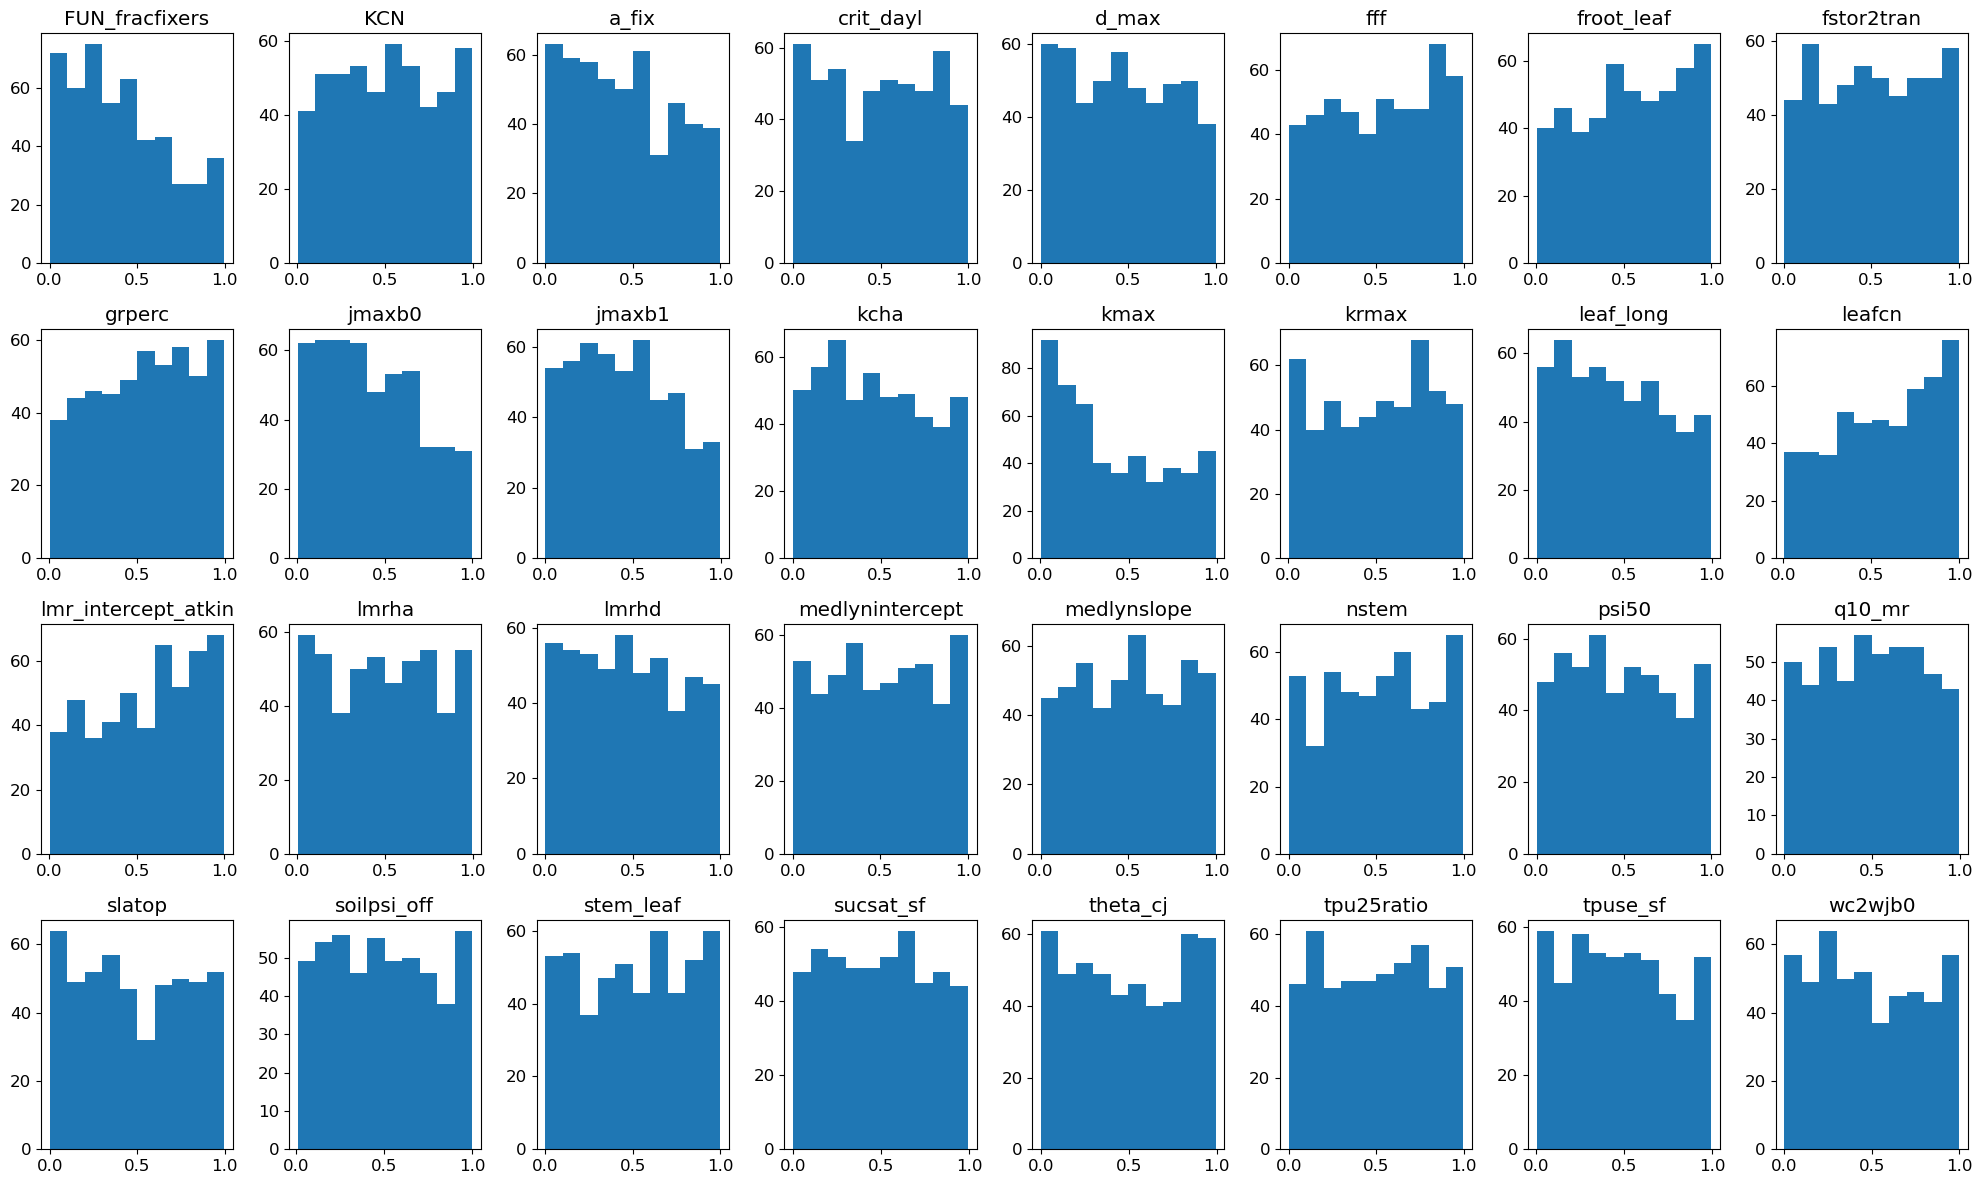

In [112]:
plt.figure(num=None, figsize=(20, 12), dpi=100, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})

for i,param in enumerate(lhc_params.columns):
    plt.subplot(4,8,i+1)
    plt.hist(df_sample[param].values)
    plt.title(param)
plt.tight_layout()
plt.savefig('final_sample_paramsettings_PFT6.png',dpi=200)

# Misc. Testing

### Select "best" pft set per Universal set

In [55]:
# for each universal sets select psets that minimize sum of I across all biomes (that p is in)
pset_id = np.empty((len(usets),16))*np.NaN
for p in range(1,16):
    ix = []
    for u in usets:
        x = pset_I[u,p,pb_index[pft_names[p]],:]
        ix.append(np.argmin(np.nansum(x,axis=0)))
    pset_id[:,p] = ix

In [267]:
pset_id[:,1]

array([66., 63.,  5., 91., 66., 66., 91., 10., 91., 53., 33., 91., 10.,
       97., 91., 70., 91., 10., 91., 26., 33., 63., 70., 33., 10., 91.,
       91., 89., 66., 26., 70., 91., 91., 97., 33., 33.,  5., 53., 91.,
       26., 26., 66., 53., 14., 70., 70., 91., 14., 64., 97., 14., 10.,
       89., 70., 91.,  5.,  5., 91., 10., 53., 33., 26., 32., 53., 33.,
       33., 89., 10., 91., 33., 70., 53., 70., 66., 70., 91., 91., 91.,
       91., 14., 12., 91., 53., 70., 10., 71., 66., 10., 91., 26., 33.,
       91., 70., 91., 53., 91., 53., 10., 91., 14., 53., 33., 53., 97.,
       26., 70., 53., 14., 53., 91., 26., 33., 10., 91., 91., 70., 70.,
       95., 33., 91., 53., 14., 91., 66., 97., 66., 14., 53., 10., 95.,
       66., 91., 14., 91., 91.,  5.,  5., 10., 33., 14., 33., 14., 53.,
       26., 91., 91., 48., 70., 53., 91., 91.,  5., 53., 66., 97., 33.,
        5., 91., 97., 91., 53., 53., 53., 37., 14., 14., 66., 12., 91.,
       66., 14., 91., 66., 89., 10., 53.,  5., 89.,  5., 89., 10

### Select Psets (priority biome)

In [268]:
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pft_names=[str(p)[2:-1].strip() for p in pfts.values]

pb_index = {}
pb_index[pft_names[1]] = [5,6]
pb_index[pft_names[2]] = [8,9]
pb_index[pft_names[3]] = [8,9]
pb_index[pft_names[4]] = [2]
pb_index[pft_names[5]] = [2]
pb_index[pft_names[6]] = [2,3]
pb_index[pft_names[7]] = [7]
pb_index[pft_names[8]] = [5,6,8,9]
pb_index[pft_names[9]] = []
pb_index[pft_names[10]] = [6,7]
pb_index[pft_names[11]] = [8,9]
pb_index[pft_names[12]] = [7,8,9] 
pb_index[pft_names[13]] = [2,3,5,6,7]
pb_index[pft_names[14]] = [2,3] 
pb_index[pft_names[15]] = [2,6]

In [269]:
pset_id = np.empty((len(usets),16))*np.NaN
for p in range(1,16):
    ix = []
    for u in usets:
        x = pset_I[u,p,pb_index[pft_names[p]],:]
        ix.append(np.argmin(np.nansum(x,axis=0)))
    pset_id[:,p] = ix

In [270]:
pset_id[:,1]

array([66., 14.,  5., 76., 66., 66., 14., 14., 91., 14., 66., 91., 14.,
       53., 91., 10., 53., 10.,  5., 91., 23., 66., 10., 66., 91., 91.,
       14., 58., 66., 14., 66., 91., 86., 91., 10., 66.,  5., 58., 91.,
       14., 14., 66., 14., 14., 10., 14., 91., 14., 14., 14., 53., 14.,
       14., 70., 14., 53., 58., 91., 10., 14., 66., 33., 14., 91., 84.,
       91., 89., 66., 91., 33., 10., 14., 66., 66., 70., 91., 91.,  5.,
       76.,  2., 66., 91., 14., 66., 10., 14., 66., 66., 91., 14., 10.,
       91., 10.,  5., 14., 91., 66., 66., 91., 14., 14., 14., 70., 14.,
       66., 70., 91., 14., 14., 91., 54., 33., 14., 14., 53., 91., 10.,
       95., 33., 14., 91., 14., 91., 14., 97., 66., 14.,  5., 10., 23.,
       66., 66., 66., 91., 53.,  5.,  5., 10., 12., 53., 37., 14., 53.,
       66., 14., 91., 66., 14., 66., 14., 14., 53., 14., 66.,  2., 17.,
        5., 14.,  5., 91., 14., 97., 76., 23., 14., 14., 66., 12., 91.,
       66., 66., 91., 66., 66., 14., 14.,  5., 58., 97., 14., 66

In [273]:
pft_sample[66,:]

array([0.8528042 , 0.97020407, 0.17367054, 0.36796524, 0.29751691,
       0.82650935, 0.21935716, 0.53091673, 0.08022918, 0.39699584,
       0.99592025, 0.97857747])

### Select favorite universal set 

In [ ]:
#(fix boring parameters at default)
# densly sample PFT parameters for this set

### Screen for biome GPP

In [ ]:
#Load ILAMB GPP datasets
ds_gpp_ilamb =xr.open_dataset('/glade/work/linnia/ILAMB/ilamb_data/regridded/ILAMB_GPP_regridded_v3.nc')
la=xr.open_dataset('../sparsegrid_landarea.nc').landarea
#ilamb_cf=1e-9*la.sum()*365
jvals, ivals = get_sparsegrid()
FLX_gpp = bmean(amean(ds_gpp_ilamb.FLUXCOM_GPP[:,jvals,ivals]).mean(dim='year'),la).compute()
wecann_gpp = bmean(amean(ds_gpp_ilamb.WECANN_GPP[:,jvals,ivals]).mean(dim='year'),la).compute()

In [ ]:
# set observational tolerance:
obs_mean = (FLX_gpp.values + wecann_gpp.values)/2
obs_diff = np.abs(FLX_gpp.values - wecann_gpp.values)
obs_range = [obs_mean - obs_diff, obs_mean + obs_diff]

In [ ]:
uset_gpp = np.empty((n_usamp,16,10))*np.NaN

for b in range(1,10):
        omin = obs_range[0][b]
        omax = obs_range[1][b]

        file1 = '/glade/work/linnia/CLM-PPE-LAI_tests/exp5_PXB/predicted/PXB_pred_12-28_GPP_biome'+str(b)+'.npy'
        y_pred_gpp = np.load(file1)
        y_pred = np.reshape(y_pred_gpp,(n_usamp,n_psamp))

        for i,u in enumerate(ix_usets_lai[0]):
            ix = ix_pset[u,p].astype(int)
            tmp = y_pred[u,ix]
           
            if np.any((y>omin) & (y<omax)):
                uset_gpp[u,b] = 1

            st = st+n_psamp

In [ ]:
utotal_gpp = np.nansum(uset_gpp,axis=1)

In [ ]:
ix_gpp = np.where(utotal_gpp==9) # All 9 biomes have at least 1 pft set within tolerance